## Visualization in jupyter notebook
### Reading in the data:

- We use `xarray` here, but you can also use e.g. iris or even pyaerocom!
- We recomend however, that you use a package that keeps track of your coordinates in your data and the metadata in your data! (E.g. numpy doesn't do this)
- This is also why the NetCDF format is so popular -- it keeps track of these things and is extremely easy to load with these packages.


In [7]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import (np, plt, xr)

# reload imports
%load_ext autoreload
%autoreload 2

In [9]:
# Load data
file = './wrf_out.small.h5'
ds = xr.open_dataset(file)

In [10]:
# Check how the dataset looks like
ds

<xarray.Dataset>
Dimensions:  (XTIME: 1449, bottom_top: 10, south_north: 17, west_east: 23)
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P        (XTIME, bottom_top, south_north, west_east) float32 ...
    V        (XTIME, bottom_top, south_north, west_east) float32 ...
    U        (XTIME, bottom_top, south_north, west_east) float32 ...
    T        (XTIME, bottom_top, south_north, west_east) float32 ...

In [11]:
# Check the attributes
ds.XTIME

<xarray.DataArray 'XTIME' (XTIME: 1449)>
array(['2017-12-02T00:00:00.000000000', '2017-12-02T03:00:00.000000000',
       '2017-12-02T06:00:00.000000000', ..., '2018-05-31T18:00:00.000000000',
       '2018-05-31T21:00:00.000000000', '2018-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2017-12-02 00:00:00
    stagger:

In [12]:
# Assign attributes and process potential temperature into degC. 
# Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray.

ds['T_C'] = ds['T'] + 300 - 273
ds['T_C'] = ds['T_C'].assign_attrs({'units': 'C'})
ds['T_C'] = ds['T_C'].assign_attrs({'description': 'Temperature in C'})

In [13]:
# Check for attributes
ds.T_C.attrs

{'units': 'C', 'description': 'Temperature in C'}

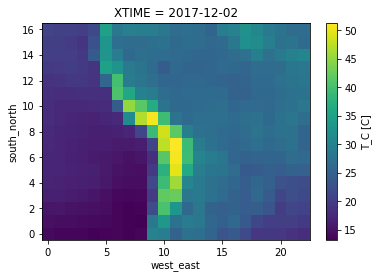

In [14]:
# Basic plot of potential temperature in degC
_t_c = ds.T_C.isel(XTIME = 0, bottom_top = 0)
_t_c.plot()

In [15]:
# Change the coordinate 'south_north' to latitude!
ds['south_north'] = ds.XLAT[:,0]
ds['west_east']   = ds.XLONG[0,:]

# Reanme the coordinates
ds = ds.rename({'south_north' : 'lat',
                'west_east'    : 'lon'})

In [16]:
# lets define some constants for the variable names so that calling them is easier.
ilev = 'bottom_top'
lat = 'lat'
lon = 'lon'
XT  = 'XTIME'
time = 'XTIME'
P, V, U, T = 'P','V','U','T'

#this is potential temperature in C
T_C = 'T_C'

In [17]:
# create new variable
WS = 'Wind speed'

ds[WS] = np.sqrt(ds[U]**2+ ds[V]**2)

ds[WS].attrs['units']='m/s'
ds[WS].attrs['long_name']='Wind SPEED'



# Plotting

In [18]:
from imports import cy, ccrs

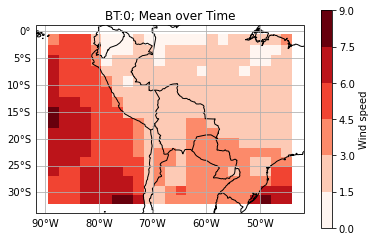

In [22]:
f,ax = plt.subplots(nrows = 1, ncols = 1, subplot_kw={'projection' : ccrs.PlateCarree()})
_ds = ds[{ilev:0}]
_dm = _ds[WS].mean([time])

_dm.plot.pcolormesh(
     cmap     = plt.get_cmap('Reds'),
     ax       = ax,
     transform = ccrs.PlateCarree(),
     levels   = 6,
)

ax.set_title('BT:0; Mean over Time')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top   = False
gl.ylabels_right = False
ax.add_feature(cy.feature.BORDERS);

In [23]:
# Making map features
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

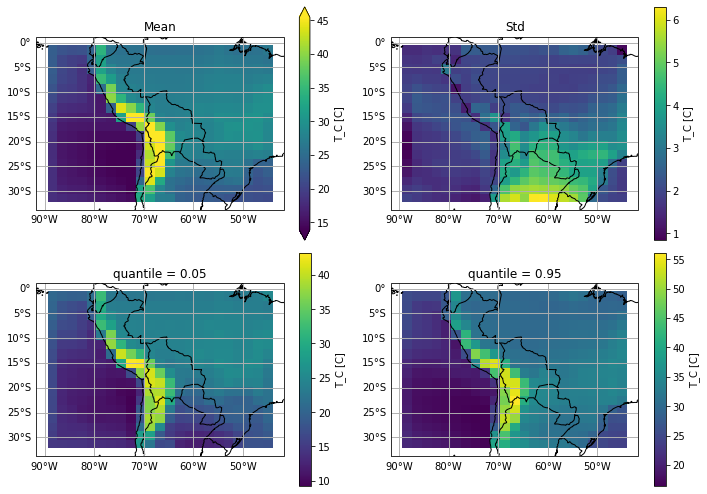

In [24]:
# Some quick statistics
fig, axsm = sp_map(2,2, 
                   figsize=[10,7], 
                   )
axs = axsm.flatten()
_ds = ds[T_C][{ilev:0}]
_ds.mean(time, keep_attrs=True).plot(ax=axs[0], 
                                     transform=ccrs.PlateCarree(), 
                                     robust=True)
axs[0].set_title('Mean')
_ds.std(time, keep_attrs=True).plot(ax=axs[1], 
                                    transform=ccrs.PlateCarree())#, robust=True)
axs[1].set_title('Std')
_ds.quantile(0.05, dim=time, keep_attrs=True).plot(ax=axs[2], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
_ds.quantile(0.95, dim=time, keep_attrs=True).plot(ax=axs[3], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
for ax in axs:
    add_map_features(ax)

plt.tight_layout()